In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

## **Data**  
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data

In [2]:
class KaggleHouseData():
    def __init__(self):
        self.raw_train = pd.read_csv('./data/house-prices-advanced-regression-techniques/train.csv')
        self.raw_test = pd.read_csv('./data/house-prices-advanced-regression-techniques/test.csv')

    def preprocess(self):
        features = pd.concat(
            [self.raw_train.drop(columns=['Id', 'SalePrice']),
             self.raw_test.drop(columns=['Id'])]
        )
        numeric_features = features.dtypes[features.dtypes != 'object'].index.tolist()
        
        mean = self.raw_train[numeric_features].mean(axis=0)
        std = self.raw_train[numeric_features].std(axis=0)
        features[numeric_features] = (features[numeric_features] - mean)/std
        
        features[numeric_features] = features[numeric_features].fillna(0)

        features = pd.get_dummies(features, dummy_na=True)  # NaN도 하나의 범주라고 여기고 one hot encoding함
        
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train['SalePrice'] = self.raw_train['SalePrice'].copy()

        self.test = features[self.raw_train.shape[0]:]

    def get_k_fold_data_loader(self, batch_size =64, k=5, seed=777):
        n = self.train.shape[0]
        rng = np.random.default_rng(seed)  # random number generator
        perm = rng.permutation(n)  # (0, 1, ..., n - 1) shuffling
        fold_ids = np.zeros(n, dtype=int)
        fold_ids[perm] = np.arange(n) % k

        rets = []
        for i in range(k):
            train_df = self.train.iloc[fold_ids != i]
            val_df = self.train.iloc[fold_ids == i]

            train_X = torch.from_numpy(train_df.drop(columns=['SalePrice']).to_numpy(dtype=np.float32))
            train_y = torch.log(torch.from_numpy(train_df[['SalePrice']].to_numpy(dtype=np.float32))).reshape(-1, 1)

            val_X = torch.from_numpy(val_df.drop(columns=['SalePrice']).to_numpy(dtype=np.float32))
            val_y = torch.log(torch.from_numpy(val_df[['SalePrice']].to_numpy(dtype=np.float32))).reshape(-1, 1)

            train_loader = DataLoader(TensorDataset(train_X, train_y), batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(TensorDataset(val_X, val_y), batch_size=batch_size, shuffle=False)

            rets.append((train_loader, val_loader))

        return rets

In [3]:
data = KaggleHouseData()
data.preprocess()

In [4]:
data.train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,SalePrice
0,0.073350,-0.207948,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.509840,0.575228,-0.288554,...,True,False,False,False,False,False,True,False,False,208500
1,-0.872264,0.409724,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.572637,1.171591,-0.288554,...,True,False,False,False,False,False,True,False,False,181500
2,0.073350,-0.084413,0.073455,0.651256,-0.517023,0.984415,0.829930,0.322063,0.092875,-0.288554,...,True,False,False,False,False,False,True,False,False,223500
3,0.309753,-0.413838,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.572637,-0.499103,-0.288554,...,True,False,True,False,False,False,False,False,False,140000
4,0.073350,0.574436,0.375020,1.374324,-0.517023,0.951306,0.733056,1.360357,0.463410,-0.288554,...,True,False,False,False,False,False,True,False,False,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.073350,-0.331482,-0.260471,-0.071812,-0.517023,0.918196,0.733056,-0.572637,-0.972685,-0.288554,...,True,False,False,False,False,False,True,False,False,175000
1456,-0.872264,0.615614,0.266316,-0.071812,0.381612,0.222899,0.151813,0.084581,0.759399,0.721865,...,True,False,False,False,False,False,True,False,False,210000
1457,0.309753,-0.166770,-0.147760,0.651256,3.077516,-1.002149,1.023678,-0.572637,-0.369744,-0.288554,...,True,False,False,False,False,False,True,False,False,266500
1458,-0.872264,-0.084413,-0.080133,-0.794879,0.381612,-0.704164,0.539309,-0.572637,-0.865252,6.090101,...,True,False,False,False,False,False,True,False,False,142125


In [5]:
data.test

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,-0.872264,0.409724,0.110725,-0.794879,0.381612,-0.339961,-1.155984,-0.572637,0.053410,0.604086,...,False,True,False,False,False,False,False,True,False,False
1,-0.872264,0.450902,0.375721,-0.071812,0.381612,-0.439289,-1.301294,0.023830,1.051003,-0.288554,...,False,True,False,False,False,False,False,True,False,False
2,0.073350,0.162655,0.331939,-0.794879,-0.517023,0.851977,0.636183,-0.572637,0.761591,-0.288554,...,False,True,False,False,False,False,False,True,False,False
3,0.073350,0.327368,-0.053984,-0.071812,0.381612,0.885087,0.636183,-0.462180,0.347207,-0.288554,...,False,True,False,False,False,False,False,True,False,False
4,1.491770,-1.113866,-0.552217,1.374324,-0.517023,0.686430,0.345561,-0.572637,-0.396055,-0.288554,...,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.437384,-2.019784,-0.859693,-1.517947,1.280247,-0.041976,-0.720051,-0.572637,-0.972685,-0.288554,...,False,True,False,False,False,False,False,True,False,False
1455,2.437384,-2.019784,-0.863901,-1.517947,-0.517023,-0.041976,-0.720051,-0.572637,-0.420172,-0.288554,...,False,True,False,True,False,False,False,False,False,False
1456,-0.872264,3.703972,0.950097,-0.794879,1.280247,-0.373070,0.539309,-0.572637,1.710948,-0.288554,...,False,True,False,True,False,False,False,False,False,False
1457,0.664358,-0.331482,-0.007597,-0.794879,-0.517023,0.686430,0.345561,-0.572637,-0.233809,-0.288554,...,False,True,False,False,False,False,False,True,False,False


In [6]:
k_fold_data_loader = data.get_k_fold_data_loader()

## **Model**

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        self.net = nn.Linear(num_inputs, 1)

    def forward(self, X):
        return self.net(X)

## **Training**  
Fold 마다 Model 하나씩...

In [8]:
%%time
num_epochs = 10

models = []
train_losses = []
val_losses = []

for fold, (train_loader, val_loader) in enumerate(k_fold_data_loader):
    model = LinearRegression(num_inputs=330)
    models.append(model)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    for i in range(num_epochs):
        train_loss = 0
        num_train_batches = 0
    
        val_loss = 0
        num_val_batches = 0
        
        model.train()

        for X, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(X)
            loss = F.mse_loss(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
    
        model.eval()
    
        for X, y in val_loader:
            with torch.no_grad():
                y_hat = model(X)
                loss = F.mse_loss(y_hat, y)
                val_loss += loss.item()
                num_val_batches += 1

        train_losses.append(train_loss/num_train_batches)
        val_losses.append(val_loss/num_val_batches)

CPU times: total: 766 ms
Wall time: 786 ms


In [9]:
avg_train_losses = np.array(train_losses).reshape(5, -1).mean(axis=0)
avg_val_losses = np.array(val_losses).reshape(5, -1).mean(axis=0)

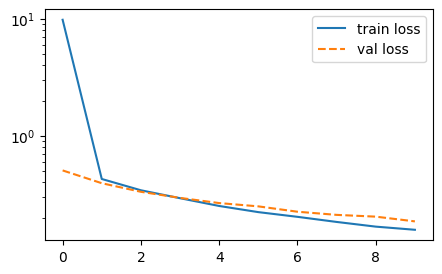

In [10]:
plt.figure(figsize=(5, 3))

plt.plot(avg_train_losses, label='train loss')
plt.plot(avg_val_losses, linestyle='--', label='val loss')

plt.yscale('log')
plt.legend()
plt.show()

## **Prediction**

In [11]:
test_X = torch.tensor(data.test.values.astype(np.float32))
test_X.shape

torch.Size([1459, 330])

In [12]:
log_preds = np.array([model(test_X).detach().numpy().flatten() for model in models])
preds = np.exp(log_preds)
preds.shape

(5, 1459)

In [13]:
ensemble_preds = preds.mean(axis=0)
ensemble_preds.shape

(1459,)

In [14]:
submission = pd.DataFrame({'Id': data.raw_test.Id,
                           'SalePrice': ensemble_preds})

In [15]:
submission.to_csv('submission.csv', index=False)

In [16]:
submission

,Id,SalePrice
0,1461,90272.898438
1,1462,621179.312500
2,1463,194154.531250
3,1464,267783.750000
4,1465,178958.625000
...,...,...
1454,2915,78813.726562
1455,2916,98275.328125
1456,2917,242184.828125
1457,2918,93938.328125
